Jakub Kuciński 309881

Rafał Nowak
# Numerical Optimization
## Problem set 1 (20 points)

**Submission deadline**: Thursday, 4.11.2021

* All submissions should contain single file.<br/>This can be single Jupyter notebook file (with extension `ipynb`) or ZIP archive in case the are some additional files needed.
* It is recommended to write the reports using LaTeX. 
* One can report the answers, comments and results in PDF or notebook file.
* All the source code should be written in Python or Julia.

Imports

In [1]:
import numpy as np
import time
import pandas as pd
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D

**Problem 1.1 (4 pts)**

In this problem you are going to solve the system of linear equations $Ax=b$, where $A\in \mathbb R^{n\times n}$, $b\in\mathbb R^n$ are given.

1. Implement the [Gauss elimination algorithm](https://www.wikiwand.com/en/Gaussian_elimination) that solves the system $Ax=b$. 
> `x = solve(A,b)`
2. Test your algorithm with built-in solver (see [`\`](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#Base.:\-Tuple{AbstractArray{T,2}%20where%20T,Union{AbstractArray{T,1},%20AbstractArray{T,2}}%20where%20T}) in Julia for example).<br/>
One can perform the tests by taking $b := Ax$ for somehow generated vector (solution) $x\in\mathbb R^n$.
3. Experiment with different kind of matrices $A$: symmetric, (2,3-)diagonal, Hilbert, positive definite, ..., 

In [4]:
def solve(A, b):
    h = 0
    k = 0
    A = np.append(A, b.reshape(-1, 1), axis=1)
    while h < A.shape[0] and k < A.shape[1]-1:
        index_max = np.argmax(np.abs(A[h:, k])) + h
        if A[index_max, k] == 0:
            k += 1
            continue
        A[[h, index_max]] = A[[index_max, h]]
        for i in range(h+1, A.shape[0]):
            f = A[i, k] / A[h, k]
            A[i, k] = 0
            A[i, k+1:] -= A[h, k+1:] * f
        h += 1
        k += 1
    if all(A[-1, :-1] == 0):
        raise Exception("Matrix A is not full rank")
    for i in range(A.shape[0]-1, -1, -1):
        f = 1/A[i, i]
        A[i, i:] *= f
        A[:i, -1] -= A[i, -1] * A[:i, i]
        A[:i, i] = 0
    return A[:, -1]

In [13]:
def test_matrices(type_of_matrix="random", N=100, A=None, b=None, left=1, right=10, verbose=True):
    """Function to test solver on different types of matrices. 
    If A and b are Nones, then they are constructed acordingly to 
    selected matrix type. In all but Hilbert matrix types there is used uniform distribution
    with interval [left, right] for sampling random numbers.
    Returns execution time of my and numpy's implementations, 
    Maximum relative error of my implementation with respect to numpy 
    (that is maximum relative error on one of the matrix fields),
    F-norm of matrices difference / F-norm of numpy_result
    """
    if A is None: 
        if type_of_matrix == "symmetric":
            M = np.random.uniform(left, right, size=(N,N))
            A = M + M.T
            
        elif type_of_matrix == "bidiagonal":
            diag = np.random.uniform(left, right, size=(N))
            upper_diag = np.random.uniform(left, right, size=(N-1))
            A = np.diag(diag) + np.diag(upper_diag, 1)
            
        elif type_of_matrix == "tridiagonal":
            diag = np.random.uniform(left, right, size=(N))
            upper_diag = np.random.uniform(left, right, size=(N-1))
            lower_diag = np.random.uniform(left, right, size=(N-1))
            A = np.diag(diag) + np.diag(upper_diag, 1) + np.diag(lower_diag, -1)
            
        elif type_of_matrix == "Hilbert":
            A = np.zeros((N, N))
            for i in range(1, 2*N):
                A += np.diag(np.zeros((min(i, 2*N - i))) + 1/(i), N-i)
            A = np.flip(A, axis=1)
                
        elif type_of_matrix == "positive definite":
            L = np.tril(np.random.uniform(left, right, size=(N)))
            A = L @ L.T
        
        else:
            A = np.random.uniform(left, right, size=(N,N))

    if b is None:
        x = np.random.uniform(left, right, size=N)
        b = A @ x

    start = time.time()
    numpy_result = np.linalg.solve(A, b)
    end = time.time()
    numpy_time = end - start

    start = time.time()
    my_result = solve(A, b)
    end = time.time()
    my_time = end - start

    max_relative_error = np.max(np.abs((my_result - numpy_result)/numpy_result))
    frobenius_norm_of_difference = np.sqrt(np.sum((my_result - numpy_result)**2))
    frobenius_norm_of_numpy_result = np.sqrt(np.sum(numpy_result**2))
    frobenius_ratio = frobenius_norm_of_difference / frobenius_norm_of_numpy_result
    if verbose:
        print(f"""Time of my implementation: {my_time}s
Time of numpy implementation: {numpy_time}s
Maximum relative error of my implementation with respect to numpy: {max_relative_error},
F-norm of difference / F-norm of numpy_result: {frobenius_ratio}""")
    return my_time, numpy_time, max_relative_error, frobenius_ratio

In [188]:
data = []
for type_of_matrix in ["symmetric", "bidiagonal", "tridiagonal", "Hilbert", "positive definite", "random"]:
    for N in [10, 100, 1000]:
        for (left, right) in [(-1.0, 1.0), (1, 10)]:
            result = test_matrices(type_of_matrix=type_of_matrix, N=N, left=left, right=right, verbose=False)
            data.append([type_of_matrix, N, left, right, result[0], result[1], result[2], result[3]])
df = pd.DataFrame(data, columns=['type_of_matrix', 'N', 'left', 'right', 'my_time', 
                                 'numpy_time', 'max_relative_error', 'frobenius_ratio'])

In [189]:
pd.set_option('precision',4)
df

,type_of_matrix,N,left,right,my_time,numpy_time,max_relative_error,frobenius_ratio
0,symmetric,10,-1.0,1.0,0.0000,0.0000,3.8754e-15,7.5644e-16
1,symmetric,10,1.0,10.0,0.0010,0.0000,3.5558e-15,1.4770e-15
2,symmetric,100,-1.0,1.0,0.0200,0.0000,2.4704e-12,9.1529e-15
3,symmetric,100,1.0,10.0,0.0189,0.0010,1.6513e-13,1.2386e-14
4,symmetric,1000,-1.0,1.0,2.4245,0.0090,5.0605e-11,2.1268e-13
5,symmetric,1000,1.0,10.0,2.3577,0.0070,9.4337e-12,3.0677e-13
6,bidiagonal,10,-1.0,1.0,0.0010,0.0000,3.6431e-16,1.4794e-16
7,bidiagonal,10,1.0,10.0,0.0000,0.0000,4.1258e-16,2.2370e-16
8,bidiagonal,100,-1.0,1.0,0.0180,0.0010,1.9233e-08,1.7000e-10
9,bidiagonal,100,1.0,10.0,0.0189,0.0000,3.6998e-12,8.5752e-14


In [190]:
pd.reset_option('precision')

Conclusions:
* My implementation solves equations much slower than the numpy implementation.
* For symmetric, tridiagonal, positive definite and random matrices results obtained by my solver are close to ones obtained by numpy.
* For Hilbert matrices of size 10x10 my solver gets reasonably well solutions, but for matrices of sizes 100x100 and 1000x1000 obtained solutions are distant from ones obtained from numpy.
* While result obtained for bidiagonal matrices of sizes 10x10 and 100x100 are close to numpy's, the results for 1000x1000 are far. Those inaccuracies appears more frequently for samling from U[-1,1] rather than U[1,10] which may be caused by some near zero numerical errors.

**Problem 1.2 (2 pts)**

Consider the following linear problem:
```
    maximize     2x+2y+z
    
                 | 1 1 1 |   | x |     | 5 |
    subject to   | 1 1 0 | * | y |  <= | 4 |
                 | 0 0 1 |   | z |     | 4 |
                 
                 x, y, z >= 0
```
* Plot the 3D polytope defined be the constraints. What is the number of vertices?
* Solve the LP.

Below is the code for ploting edges of polytope and code for plotting polytope with surface 2x+2y+z=9 (I find ploted edges more clear than making a grid of points and ploting ones that satisfies constrains, though it took me much more work to determine them).

<IPython.core.display.Javascript object>


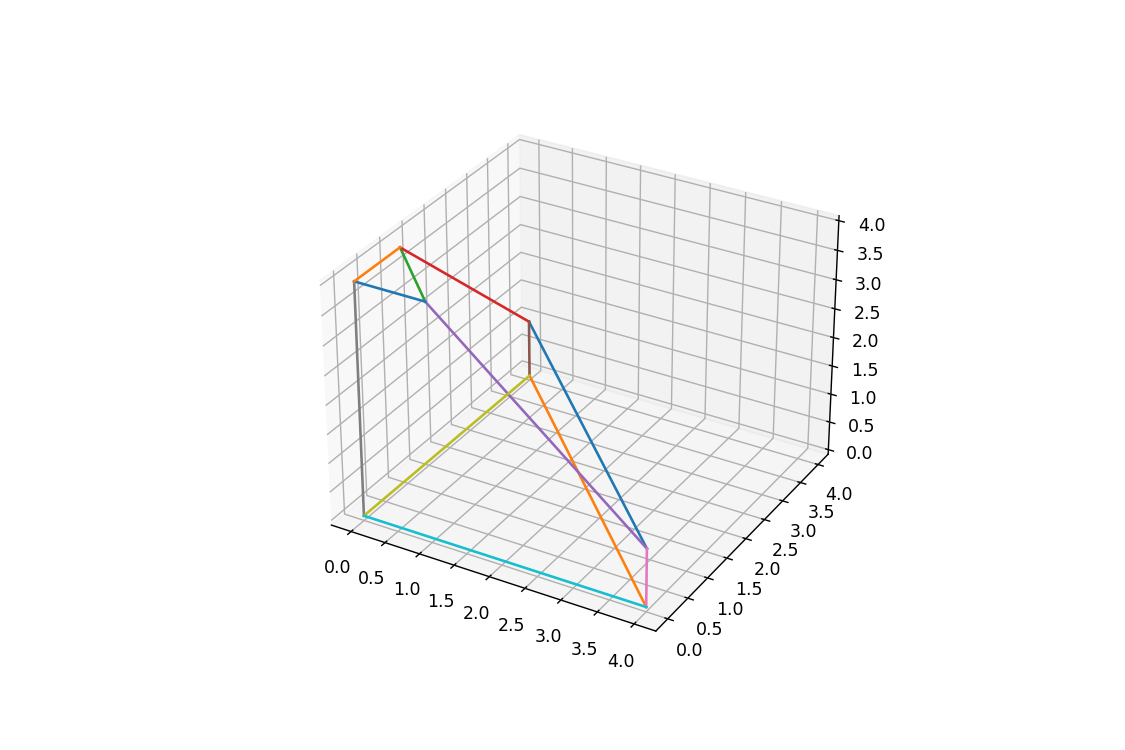

In [106]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
n = 1000
ax.plot(np.linspace(0, 4, n), 4 - np.linspace(0, 4, n), zs = np.zeros(n) + 1)
ax.plot(np.linspace(0, 4, n), 4 - np.linspace(0, 4, n), zs = np.zeros(n))
ax.plot(np.linspace(0, 1, n), 1 - np.linspace(0, 1, n), zs = np.zeros(n) + 4)
ax.plot(np.zeros(n), np.linspace(1, 4, n), zs = 5 -  np.linspace(1, 4, n))
ax.plot(np.linspace(1, 4, n), np.zeros(n), zs = 5 -  np.linspace(1, 4, n))
ax.plot(np.zeros(n), np.zeros(n) + 4, zs = np.linspace(0, 1, n))
ax.plot(np.zeros(n) + 4, np.zeros(n), zs = np.linspace(0, 1, n))
ax.plot(np.zeros(n), np.zeros(n), zs=np.linspace(0, 4, n))
ax.plot(np.zeros(n), np.linspace(0, 4, n), zs=np.zeros(n))
ax.plot(np.linspace(0, 4, n), np.zeros(n), zs=np.zeros(n))
ax.plot(np.linspace(0, 1, n), np.zeros(n), zs=np.zeros(n)+4)
ax.plot(np.zeros(n), np.linspace(0, 1, n), zs=np.zeros(n)+4)
plt.show()

<IPython.core.display.Javascript object>


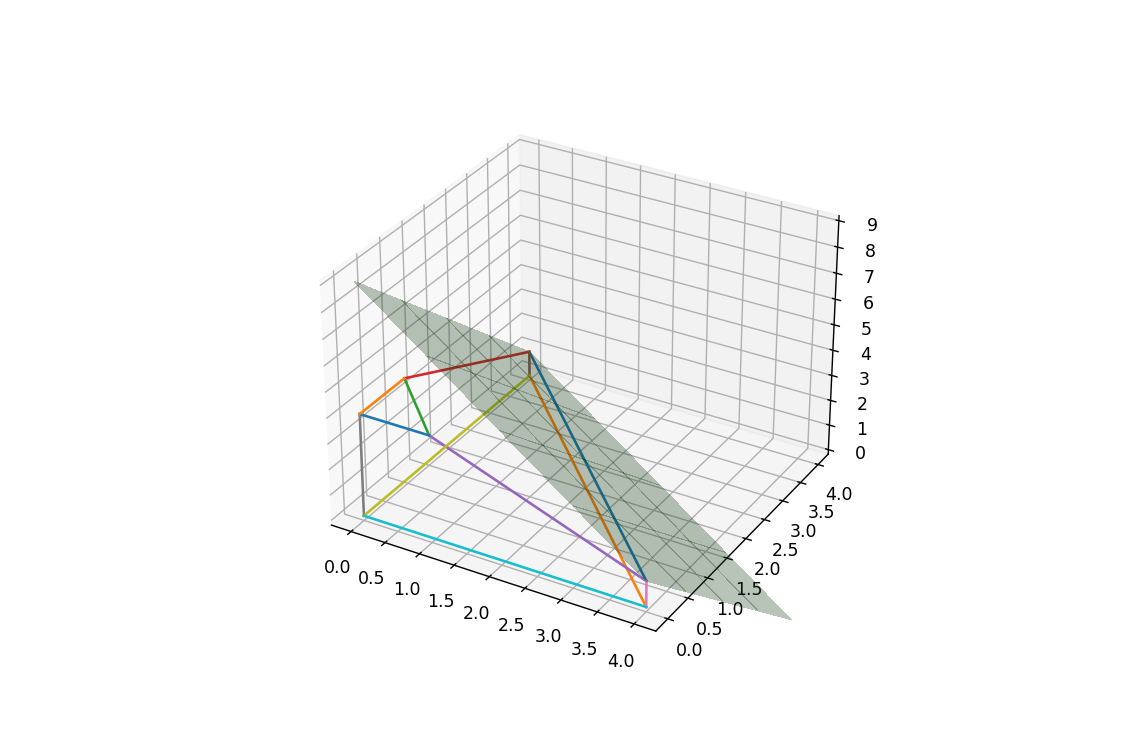

In [105]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
n = 1000
ax.plot(np.linspace(0, 4, n), 4 - np.linspace(0, 4, n), zs = np.zeros(n) + 1)
ax.plot(np.linspace(0, 4, n), 4 - np.linspace(0, 4, n), zs = np.zeros(n))
ax.plot(np.linspace(0, 1, n), 1 - np.linspace(0, 1, n), zs = np.zeros(n) + 4)
ax.plot(np.zeros(n), np.linspace(1, 4, n), zs = 5 -  np.linspace(1, 4, n))
ax.plot(np.linspace(1, 4, n), np.zeros(n), zs = 5 -  np.linspace(1, 4, n))
ax.plot(np.zeros(n), np.zeros(n) + 4, zs = np.linspace(0, 1, n))
ax.plot(np.zeros(n) + 4, np.zeros(n), zs = np.linspace(0, 1, n))
ax.plot(np.zeros(n), np.zeros(n), zs=np.linspace(0, 4, n))
ax.plot(np.zeros(n), np.linspace(0, 4, n), zs=np.zeros(n))
ax.plot(np.linspace(0, 4, n), np.zeros(n), zs=np.zeros(n))
ax.plot(np.linspace(0, 1, n), np.zeros(n), zs=np.zeros(n)+4)
ax.plot(np.zeros(n), np.linspace(0, 1, n), zs=np.zeros(n)+4)

x = np.linspace(0, 4, 5)
y = np.linspace(0, 4, 5)
X, Y = np.meshgrid(x, y)
Z = 9-2*X-2*Y
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      linewidth=0, antialiased=False, alpha=0.3)
ax.set_zlim(0,9)
plt.show()

From above plot, we can see that the dark blue edge which stands for z=1, x+y=4 is the edge that have intersection with goal function suface 2x+2y+z=C for greatest value of C (such maximum C is 9 as in code above) so it consists of optimal solutions. We will check that indeed points from x+y=4, z=1 lies on surface 2x+2y+z=9:

2x+2y+z = 2x+2(4-x)+1 =  2x+8-2x+1 = 9.

<!-- For convinence will check that x=0, y=4, z=1 is optimal solutions. We can check, that these values satifies all constrains. If we add extra variables t1, t2, t3 (one in each inequality to change them into equality) we get:
```
    minimize     -2x-2y-z
    
                 | 1 1 1 1 0 0|        | 5 |
    subject to   | 1 1 0 0 1 0| * X <= | 4 |
                 | 0 0 1 0 0 1|        | 4 |
                 
                 x, y, z >= 0
```
``` 
        | 1 1 1|      | 1 0 0|                           | 1 1 1|^-1^T
    B = | 1 1 0|, N = | 0 1 0|, - (B^-1 * N)^T * c_b = - | 1 1 0|    * (-2, -2, -1) = - (-1, -1, 0) >= 0
        | 0 0 1|      | 0 0 1|                           | 0 0 1|
```
B^-1 is pseudoinverse of B
```
c_n = (0, 0, 0)
```
So r = (0, c_N  - B^-1 * N * c_b) >= 0. Therfore solution is optimal.  -->

**Problem 1.3 (6 pts)**

Implement the simplex algorithm solving the problem
```
   minimize c^T x
   subject to Ax = b and x >= 0
```
You can assume that the initial *feasible base* (see [BFS](https://www.wikiwand.com/en/Basic_feasible_solution)) $I$ is given.<br/>
Your function should output the optimal value and the minimizer $x$.

In [2]:
data = np.load('simplex_test_data.npz', allow_pickle=True)['data'].item()

In [11]:
def simplex_method(I, c, A, b):
    J = I
    while True:
        B = A[:, J]
        J_N = np.setdiff1d(np.arange(A.shape[1]), J)
        N = A[:, J_N]
        c_B = c[J]
        c_N = c[J_N]
        B_inv = np.linalg.inv(B)
        x_B = B_inv @ b
        B_inv_N = B_inv @ N
        r_value = c_N - B_inv_N.T @ c_B
        if all(r_value >= 0):
            x = np.zeros(A.shape[1])
            x[J] = x_B
            return np.sum(c_B * x_B), x
        min_r_i = np.argmin(r_value)
        i = J_N[min_r_i]
        B_inv_A_i = B_inv @ A[:, i]
        if all(B_inv_A_i <= 0):
            raise Exception("Goal function is unbounded from below!")
        ratio = x_B / B_inv_A_i
        min_ratio_j = np.where(ratio > 0, ratio, np.inf).argmin()
        if np.isnan(ratio[min_ratio_j]) or np.abs(ratio[min_ratio_j]) == np.inf:
            raise Exception("Degeneracy!")
        j = J[min_ratio_j]
        J = np.where(J != j, J, i)
        J_N = np.where(J_N != i, J_N, j)

In [26]:
for i in range(1, 41):
    f_value, x_value = simplex_method(data[i]['I'],data[i]['c'],data[i]['A'],data[i]['b'])
    if data[i]['x'].shape != x_value.shape:
        print("Test dimensinality mismatch - can't compare solutions!", i, data[i]['A'].shape, data[i]['x'].shape, x_value.shape)
        continue
    if data[i]['f'] - f_value >= 10e-10 or any(data[i]['x'] - x_value >= 10e-10):
        print(i)
        continue
    print(f"Test {i} passed")

Test 1 passed
Test 2 passed
Test 3 passed
Test 4 passed
Test 5 passed
Test 6 passed
Test 7 passed
Test 8 passed
Test 9 passed
Test 10 passed
Test 11 passed
Test 12 passed
Test 13 passed
Test 14 passed
Test 15 passed
Test 16 passed
Test 17 passed
Test 18 passed
Test 19 passed
Test 20 passed
Test 21 passed
Test 22 passed
Test 23 passed
Test 24 passed
Test 25 passed
Test 26 passed
Test 27 passed
Test 28 passed
Test 29 passed
Test 30 passed
Test dimensinality mismatch - can't compare solutions! 31 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 32 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 33 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 34 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 35 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 36 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 37 (20, 50) (51,) (50,)
Test d

**Problem 1.4 (3 pts)**

In the problem 1.3, your implementation may have done a lot of inverse operations.

This task is to implement *revised simplex algorithm* with incremental A inverse computation 
by using the **[Sherman-Morrison](https://www.wikiwand.com/en/Sherman%E2%80%93Morrison_formula)** formula for keeping track of the inverse matrix.

Your program will be graded based on how fast it is.
You should expect to see a factor 10-20 speedup depending on the problem instance.


In [29]:
def revised_simplex_method(I, c, A, b):
    J = I
    B = A[:, J]
    J_N = np.setdiff1d(np.arange(A.shape[1]), J)
    N = A[:, J_N]
    c_B = c[J]
    c_N = c[J_N]
    B_inv = np.linalg.inv(B)
    x_B = B_inv @ b
    while True:
        B_inv_N = B_inv @ N
        r_value = c_N - B_inv_N.T @ c_B
        if all(r_value >= 0):
            x = np.zeros(A.shape[1])
            x[J] = x_B
            return np.sum(c_B * x_B), x
        min_r_i = np.argmin(r_value)
        i = J_N[min_r_i]
        B_inv_A_i = B_inv @ A[:, i]
        if all(B_inv_A_i <= 0):
            raise Exception("Goal function is unbounded from below!")
        ratio = x_B / B_inv_A_i
        min_ratio_j = np.where(ratio > 0, ratio, np.inf).argmin()
        if np.isnan(ratio[min_ratio_j]) or np.abs(ratio[min_ratio_j]) == np.inf:
            raise Exception("Degeneracy!")
        j = J[min_ratio_j]
        J = np.where(J != j, J, i)
        J_N = np.where(J_N != i, J_N, j)
        B = A[:, J]
        J_N = np.setdiff1d(np.arange(A.shape[1]), J)
        N = A[:, J_N]
        c_B = c[J]
        c_N = c[J_N]
        v = np.zeros(x_B.shape[0])
        v[min_ratio_j] = 1.0
        u = A[:, i] - A[:, j]
#         B_inv = B_inv - ((B_inv @ u).reshape(-1, 1) @ (v @ B_inv).reshape(1, -1)) / (1 + (v @ B_inv) @ u)
#         B_inv = B_inv - ((B_inv @ u).reshape(-1, 1) @ B_inv[min_ratio_j].reshape(1, -1)) / (1 + B_inv[min_ratio_j] @ u)
#         B_inv = B_inv - np.outer((B_inv @ u), (v @ B_inv)) / (1 + (v @ B_inv) @ u)
#         B_inv = B_inv - (B_inv_A_i - v).reshape(-1,1) @ B_inv[min_ratio_j].reshape(1, -1) / B_inv_A_i[min_ratio_j]
        B_inv = B_inv - np.outer(B_inv_A_i - v, B_inv[min_ratio_j]) / B_inv_A_i[min_ratio_j]
        x_B = B_inv @ b

In [25]:
for i in range(1, 41):
    f_value, x_value = revised_simplex_method(data[i]['I'],data[i]['c'],data[i]['A'],data[i]['b'])
    if data[i]['x'].shape != x_value.shape:
        print("Test dimensinality mismatch - can't compare solutions!", i, data[i]['A'].shape, data[i]['x'].shape, x_value.shape)
        continue
    if data[i]['f'] - f_value >= 10e-10 or any(data[i]['x'] - x_value >= 10e-10):
        print("Big difference of solutions", i)
        continue
    print(f"Test {i} passed")

Test 1 passed
Test 2 passed
Test 3 passed
Test 4 passed
Test 5 passed
Test 6 passed
Test 7 passed
Test 8 passed
Test 9 passed
Test 10 passed
Test 11 passed
Test 12 passed
Test 13 passed
Test 14 passed
Test 15 passed
Test 16 passed
Test 17 passed
Test 18 passed
Test 19 passed
Test 20 passed
Test 21 passed
Test 22 passed
Test 23 passed
Test 24 passed
Test 25 passed
Test 26 passed
Test 27 passed
Test 28 passed
Test 29 passed
Test 30 passed
Test dimensinality mismatch - can't compare solutions! 31 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 32 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 33 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 34 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 35 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 36 (20, 50) (51,) (50,)
Test dimensinality mismatch - can't compare solutions! 37 (20, 50) (51,) (50,)
Test d

In [86]:
start = time.time()
for i in range(10):
    for i in range(1, 41):
        f_value, x_value = simplex_method(data[i]['I'],data[i]['c'],data[i]['A'],data[i]['b'])
end = time.time()
simplex_time = end - start

In [87]:
start = time.time()
for i in range(10):
    for i in range(1, 41):
        f_value, x_value = revised_simplex_method(data[i]['I'],data[i]['c'],data[i]['A'],data[i]['b'])
end = time.time()
revised_simplex_time = end - start

In [88]:
print(simplex_time, revised_simplex_time)

0.8696727752685547 0.6432781219482422
